# RNN for Classifying Names

Note: This notebook follows in large parts  the notebook from Sean Robertson which you can find here:`<https://github.com/spro/practical-pytorch>`

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

### Preparing the Data

Download the data from here
   ` <https://download.pytorch.org/tutorial/data.zip>`
   and extract it to the `data` directory.

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

In [1]:
import string
import unicodedata

# these is the vocabulary we will use
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(f"Vocab is of size {n_letters} and contains:", all_letters)

Vocab is of size 57 and contains: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [2]:
# we convert anything into ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Heute ist es schön heiß'))

Slusarski
Heute ist es schon hei


In [3]:
from io import open
import glob
import os

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

all_categories = []
X = []
y = []

for filename in glob.glob('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(category)
    
n_categories = len(all_categories)
n_categories, len(X)

(18, 20074)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train data points:", len(X_train))

Train data points: 16059


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [5]:
import torch

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    index = all_letters.find(letter)
    tensor[0][index] = 1
    return tensor

print(letterToTensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [6]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        index = all_letters.find(letter)
        tensor[i][0][index] = 1
    return tensor

print(lineToTensor('Jones').size())

torch.Size([5, 1, 57])


In [7]:
def categoryToTensor(category):
    index = all_categories.index(category)
    return torch.tensor([index], dtype=torch.long)

categoryToTensor("Korean")

tensor([16])

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.
You can see the architecture here: https://i.imgur.com/Z2xbySO.png

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = 128 # number of hidden layer size

        self.i2h = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(input_size + self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [9]:
rnn = RNN(n_letters, n_categories)

x = letterToTensor('A')
hidden = torch.zeros(1, 128)

output, next_hidden = rnn(x, hidden)
print(torch.softmax(output, 1))

tensor([[0.0530, 0.0582, 0.0559, 0.0481, 0.0569, 0.0575, 0.0594, 0.0555, 0.0637,
         0.0541, 0.0513, 0.0594, 0.0516, 0.0513, 0.0527, 0.0557, 0.0572, 0.0586]],
       grad_fn=<SoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [10]:
import math

# Keep track of losses for plotting
current_loss = 0
all_losses = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.005)

for epoch in range(1, 10):
    
    for i in range(0, len(X_train)):
        hidden = rnn.initHidden()
        optimizer.zero_grad()
        
        line = X_train[i] # Baarle
        line_tensor = lineToTensor(line)
        
        category = y_train[i] # Dutch
        category_tensor = categoryToTensor(category)
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        loss = criterion(output, category_tensor)
        loss.backward()
    
        optimizer.step()
    
        current_loss += loss.item()

    all_losses.append(current_loss)
    print(f"Loss in epoch {epoch} is {current_loss/len(X_train)}")
    current_loss = 0

Loss in epoch 1 is 1.4326586759991504
Loss in epoch 2 is 1.120601071009915
Loss in epoch 3 is 1.0140432447121082
Loss in epoch 4 is 0.9546429199808357
Loss in epoch 5 is 0.9156462216209961
Loss in epoch 6 is 0.888426669554454
Loss in epoch 7 is 0.866464189422653
Loss in epoch 8 is 0.8495533251452998
Loss in epoch 9 is 0.8349207292691623


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




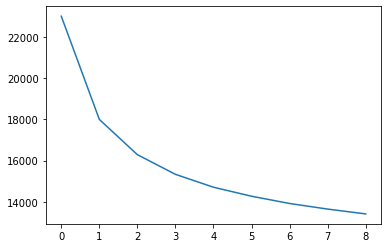

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating the Results

In [12]:
correct = 0
for i in range(0, len(X_test)):
    hidden = rnn.initHidden()
    
    line = X_test[i]
    line_tensor = lineToTensor(line)

    category = y_test[i]
    category_tensor = categoryToTensor(category)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    prediction = torch.argmax(output, 1).item()
    category_index = all_categories.index(category)
    
    if category_index == prediction:
        correct += 1
    
print("Accuracy: ", correct/len(X_test))   

Accuracy:  0.753175591531756


Running on User Input
---------------------




In [13]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    
    hidden = rnn.initHidden()

    line_tensor = lineToTensor(input_line)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Get top N categories
    output = torch.softmax(output, 1)
    topv, topi = output.topk(n_predictions, 1, True)
    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.89) Russian
(0.04) English
(0.04) Czech
(0.02) Polish
(0.00) Greek

> Jackson
(0.64) English
(0.20) Russian
(0.05) Scottish
(0.02) Greek
(0.02) Czech

> Satoshi
(0.42) Japanese
(0.20) Arabic
(0.09) Russian
(0.08) Polish
(0.06) Italian
